In [1]:
import os
import sys
import time 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
if '..' not in sys.path: sys.path.insert(0, '..')
# from encore.model import Decoder, Sequential
from utils.initialization import *
from utils.distribution_utils import *
from utils.eval import *
from generation_utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
os.chdir('..')
size_dir = './data/size/'
interval_dir = './data/interval/'
metadata_dir = './data/metadata/'
size_cdf = pd.read_csv('./data/cdf/size_cdf.csv')
interval_cdf = pd.read_csv('./data/cdf/interval_cdf.csv')
n_size = len(size_cdf) - 1
n_interval = len(interval_cdf) - 1
files = os.listdir(size_dir)
block_size = 30

In [3]:
result_dir = './results'
app = 'app_182'
jsds = {}
dists = {}
for algo in ['common', 'lomas', 'encore']:
    jsds_file = os.path.join(result_dir, '{}/{}/jsds.csv'.format(app, algo))
    jsds[algo] = pd.read_csv(jsds_file)
    interval_dist_file = os.path.join(result_dir, '{}/{}/interval_dist.txt'.format(app, algo))
    size_dist_file = os.path.join(result_dir, '{}/{}/size_dist.txt'.format(app, algo))
    total_dist_file = os.path.join(result_dir, '{}/{}/total_dist.txt'.format(app, algo))
    jsds_file = os.path.join(result_dir, '{}/{}/jsds.csv'.format(app, algo))
    dists[algo] = {'interval': np.loadtxt(interval_dist_file, delimiter=','), 'size': np.loadtxt(size_dist_file, delimiter=','), 'total': np.loadtxt(total_dist_file, delimiter=',')}
    jsds[algo] = pd.read_csv(jsds_file)

In [4]:
accuracy, coverage = {}, {}
for algo in ['common', 'lomas', 'encore']:
    accuracy[algo] = {}
    coverage[algo] = {}
    for metric in ['size', 'interval', 'total']:
        accuracy[algo][metric] = np.min(dists[algo][metric], axis=0)
        coverage[algo][metric] = np.min(dists[algo][metric], axis=1)

for metric in ['size', 'interval', 'total']:
    print('{}, accuracy: {:.4f}/{:.4f}/{:.4f}'.format(metric, accuracy['common'][metric].mean(), accuracy['lomas'][metric].mean(), accuracy['encore'][metric].mean()))
    print('{}, coverage: {:.4f}/{:.4f}/{:.4f}'.format(metric, coverage['common'][metric].mean(), coverage['lomas'][metric].mean(), coverage['encore'][metric].mean()))

size, accuracy: 0.0150/0.0150/0.0101
size, coverage: 0.0467/0.0116/0.0087
interval, accuracy: 0.0334/0.0160/0.0151
interval, coverage: 0.0742/0.0228/0.0171
total, accuracy: 0.0725/0.0378/0.0312
total, coverage: 0.1210/0.0413/0.0311


In [5]:
def plot_bar(data, fig):
    plt.subplots_adjust(left=0.15, top=0.95, bottom=0.1, right=0.99)
    ax = plt.subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.bar(np.arange(5) * 3, data['common'], width=0.8, label='Common Practice', color='SlateGray')
    plt.bar(np.arange(5) * 3 + 0.8, data['lomas'], width=0.8, label='Lomas', color='IndianRed')
    plt.bar(np.arange(5) * 3 + 1.6, data['encore'], width=0.8, label='Encore-Decoder', color='CornFlowerBlue')
    plt.grid(linestyle='-.')

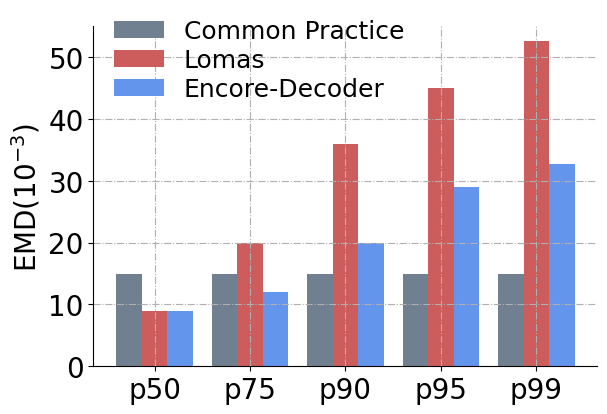

In [6]:
data = {}
data['common'] = np.percentile(accuracy['common']['size'], [50, 75, 90, 95, 99])
data['lomas'] = np.percentile(accuracy['lomas']['size'], [50, 75, 90, 95, 99])
data['encore'] = np.percentile(accuracy['encore']['size'], [50, 75, 90, 95, 99])
fig = plt.figure(figsize=(6, 4))
plot_bar(data, fig)
plt.legend(fontsize=18, frameon=False, loc=(0.02, 0.75), labelspacing=0.2)
plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.055)
plt.yticks(np.arange(0, 0.051, 0.01), np.arange(0, 51, 10), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.savefig('figures/evaluation/evaluation_size_accuracy.pdf', dpi=400)

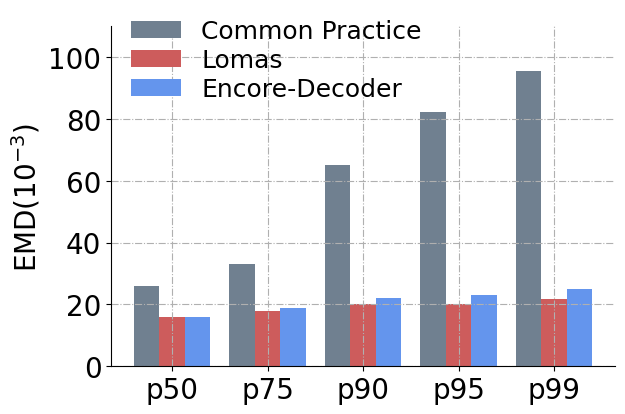

In [7]:
data = {}
data['common'] = np.percentile(accuracy['common']['interval'], [50, 75, 90, 95, 99])
data['lomas'] = np.percentile(accuracy['lomas']['interval'], [50, 75, 90, 95, 99])
data['encore'] = np.percentile(accuracy['encore']['interval'], [50, 75, 90, 95, 99])

fig = plt.figure(figsize=(6, 4))
plot_bar(data, fig)
plt.legend(fontsize=18, frameon=False, loc=(0.02, 0.75), labelspacing=0.2)
plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.11)
plt.yticks(np.arange(0, 0.12, 0.02), np.arange(0, 120, 20), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
plt.savefig('figures/evaluation/evaluation_interval_accuracy.pdf', dpi=400)

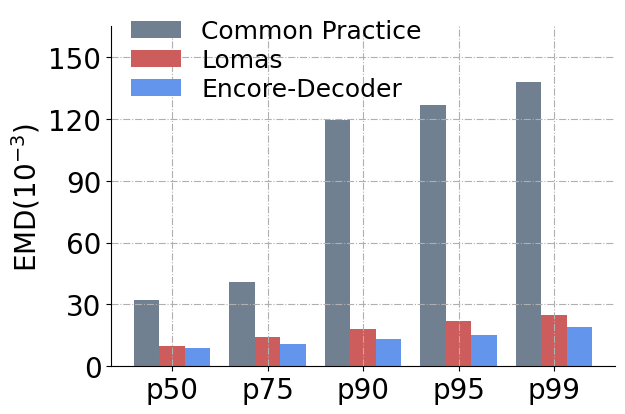

In [8]:
data = {}
data['common'] = np.percentile(coverage['common']['size'], [50, 75, 90, 95, 99])
data['lomas'] = np.percentile(coverage['lomas']['size'], [50, 75, 90, 95, 99])
data['encore'] = np.percentile(coverage['encore']['size'], [50, 75, 90, 95, 99])

fig = plt.figure(figsize=(6, 4))
plot_bar(data, fig)
plt.legend(fontsize=18, frameon=False, loc=(0.02, 0.75), labelspacing=0.2)
plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.165)
plt.yticks(np.arange(0, 0.18, 0.03), np.arange(0, 180, 30), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
plt.savefig('figures/evaluation/evaluation_size_coverage.pdf', dpi=400)

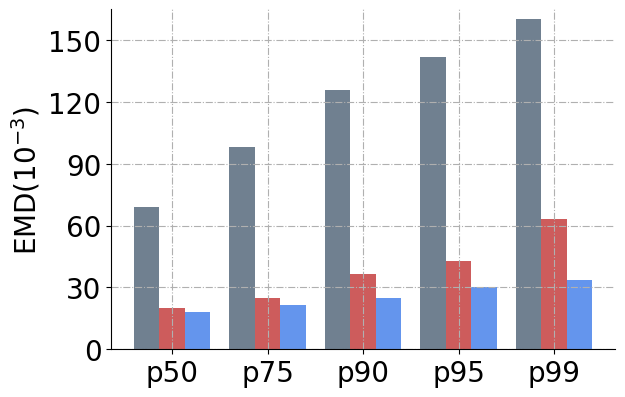

In [9]:
data = {}
data['common'] = np.percentile(coverage['common']['interval'], [50, 75, 90, 95, 99])
data['lomas'] = np.percentile(coverage['lomas']['interval'], [50, 75, 90, 95, 99])
data['encore'] = np.percentile(coverage['encore']['interval'], [50, 75, 90, 95, 99])
fig = plt.figure(figsize=(6, 4))
plot_bar(data, fig)
plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.165)
plt.yticks(np.arange(0, 0.16, 0.03), np.arange(0, 160, 30), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
plt.savefig('figures/evaluation/evaluation_interval_coverage.pdf', dpi=400)

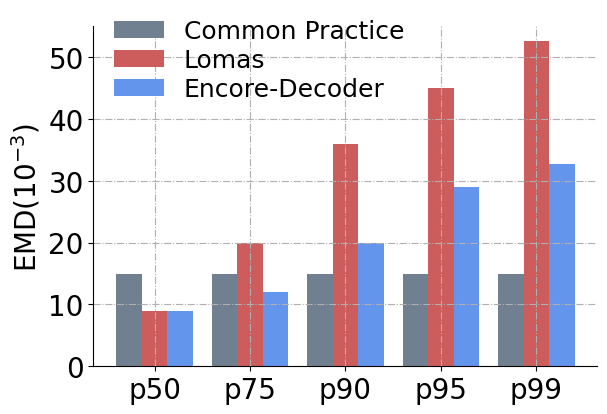

In [10]:
common_accuracy_percentile = np.percentile(accuracy['common']['size'], [50, 75, 90, 95, 99])
lomas_accuracy_percentile = np.percentile(accuracy['lomas']['size'], [50, 75, 90, 95, 99])
encore_accuracy_percentile = np.percentile(accuracy['encore']['size'], [50, 75, 90, 95, 99])
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=0.15, top=0.95, bottom=0.1, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(np.arange(5) * 3, common_accuracy_percentile, width=0.8, label='Common Practice', color='SlateGray')
plt.bar(np.arange(5) * 3 + 0.8, lomas_accuracy_percentile, width=0.8, label='Lomas', color='IndianRed')
plt.bar(np.arange(5) * 3 + 1.6, encore_accuracy_percentile, width=0.8, label='Encore-Decoder', color='CornFlowerBlue')

plt.legend(fontsize=18, frameon=False, loc=(0.02, 0.75), labelspacing=0.2)
plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.055)
plt.yticks(np.arange(0, 0.051, 0.01), np.arange(0, 51, 10), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
# plt.savefig('figures/evaluation/evaluation_size_accuracy.pdf', dpi=400)

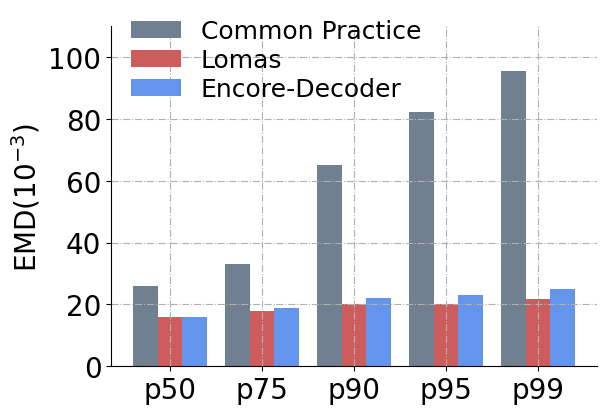

In [11]:
common_accuracy_percentile = np.percentile(accuracy['common']['interval'], [50, 75, 90, 95, 99])
lomas_accuracy_percentile = np.percentile(accuracy['lomas']['interval'], [50, 75, 90, 95, 99])
encore_accuracy_percentile = np.percentile(accuracy['encore']['interval'], [50, 75, 90, 95, 99])
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=0.18, top=0.95, bottom=0.1, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(np.arange(5) * 3, common_accuracy_percentile, width=0.8, label='Common Practice', color='SlateGray')
plt.bar(np.arange(5) * 3 + 0.8, lomas_accuracy_percentile, width=0.8, label='Lomas', color='IndianRed')
plt.bar(np.arange(5) * 3 + 1.6, encore_accuracy_percentile, width=0.8, label='Encore-Decoder', color='CornFlowerBlue')

plt.legend(fontsize=18, frameon=False, loc=(0.02, 0.75), labelspacing=0.2)
plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.11)
plt.yticks(np.arange(0, 0.12, 0.02), np.arange(0, 120, 20), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
# plt.savefig('figures/evaluation/evaluation_interval_accuracy.pdf', dpi=400)

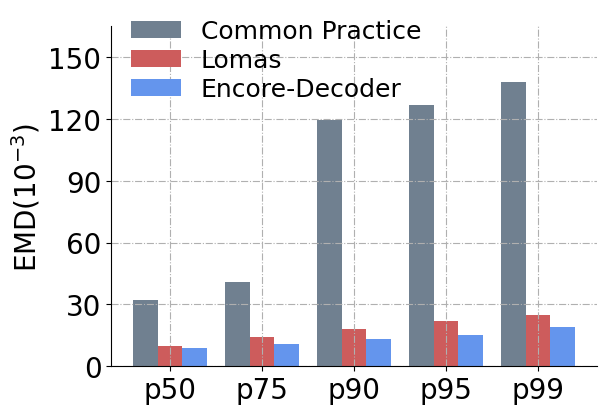

In [12]:
common_coverage_percentile = np.percentile(coverage['common']['size'], [50, 75, 90, 95, 99])
lomas_coverage_percentile = np.percentile(coverage['lomas']['size'], [50, 75, 90, 95, 99])
encore_coverage_percentile = np.percentile(coverage['encore']['size'], [50, 75, 90, 95, 99])
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=0.18, top=0.95, bottom=0.1, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(np.arange(5) * 3, common_coverage_percentile, width=0.8, label='Common Practice', color='SlateGray')
plt.bar(np.arange(5) * 3 + 0.8, lomas_coverage_percentile, width=0.8, label='Lomas', color='IndianRed')
plt.bar(np.arange(5) * 3 + 1.6, encore_coverage_percentile, width=0.8, label='Encore-Decoder', color='CornFlowerBlue')

plt.legend(fontsize=18, frameon=False, loc=(0.02, 0.75), labelspacing=0.2)
plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.165)
plt.yticks(np.arange(0, 0.18, 0.03), np.arange(0, 180, 30), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
# plt.savefig('figures/evaluation/evaluation_size_coverage.pdf', dpi=400)

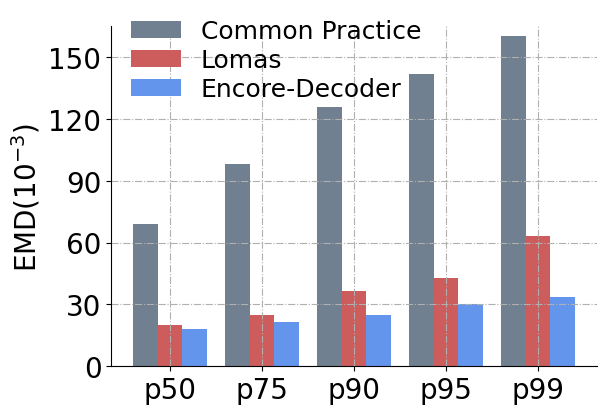

In [13]:
common_coverage_percentile = np.percentile(coverage['common']['interval'], [50, 75, 90, 95, 99])
lomas_coverage_percentile = np.percentile(coverage['lomas']['interval'], [50, 75, 90, 95, 99])
encore_coverage_percentile = np.percentile(coverage['encore']['interval'], [50, 75, 90, 95, 99])
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=0.18, top=0.95, bottom=0.1, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(np.arange(5) * 3, common_coverage_percentile, width=0.8, label='Common Practice', color='SlateGray')
plt.bar(np.arange(5) * 3 + 0.8, lomas_coverage_percentile, width=0.8, label='Lomas', color='IndianRed')
plt.bar(np.arange(5) * 3 + 1.6, encore_coverage_percentile, width=0.8, label='Encore-Decoder', color='CornFlowerBlue')
plt.legend(fontsize=18, frameon=False, loc=(0.02, 0.75), labelspacing=0.2)

plt.xticks(np.arange(5) * 3 + 0.8, ['p50', 'p75', 'p90', 'p95', 'p99'], fontsize=20)
plt.ylim(0, 0.165)
plt.yticks(np.arange(0, 0.16, 0.03), np.arange(0, 160, 30), fontsize=20)
plt.ylabel('EMD($10^{-3}$)', fontsize=20)
plt.grid(linestyle='-.')
# plt.savefig('figures/evaluation/evaluation_interval_coverage.pdf', dpi=400)

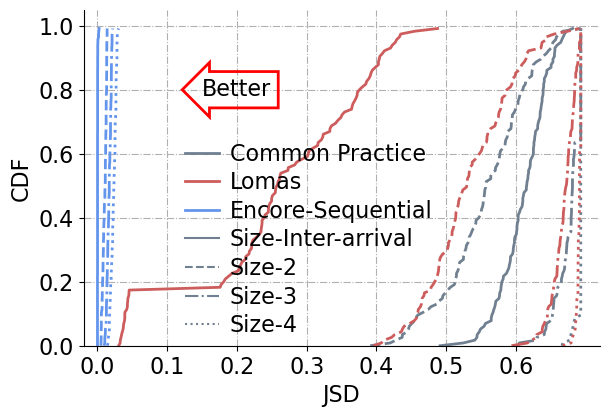

In [14]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=0.13, top=0.99, bottom=0.15, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

linestyles = ['-', '--', '-.', ':']
plot_cdf(jsds['common']['size_interval'].values, label='Common Practice', color='SlateGray', linestyle=linestyles[0])
plot_cdf(jsds['lomas']['size_interval'].values, label='Lomas', color='IndianRed', linestyle=linestyles[0])
plot_cdf(jsds['encore']['size_interval'].values, label='Encore-Sequential', color='CornFlowerBlue', linestyle=linestyles[0])

for i in range(2, 5):
    plot_cdf(jsds['common']['size_{}'.format(i)].values, label=None, color='SlateGray', linestyle=linestyles[i-1])
    plot_cdf(jsds['lomas']['size_{}'.format(i)].values, label=None, color='IndianRed', linestyle=linestyles[i-1])
    plot_cdf(jsds['encore']['size_{}'.format(i)].values, label=None, color='CornFlowerBlue', linestyle=linestyles[i-1])

plt.xlim(-0.02, 0.72)
plt.ylim(0, 1.05)
plt.ylabel('CDF', fontsize=16)
plt.xlabel('JSD', fontsize=16)
plt.grid(linestyle='-.')
plt.xticks(np.arange(0, 0.7, 0.1), fontsize=16)
plt.yticks(fontsize=16)

bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
t = ax.text(0.2, 0.8, "Better", ha="center", va="center", rotation=0,
            size=16,
            bbox=bbox_props)

linestyle_labels = ['Size-Inter-arrival', 'Size-2', 'Size-3', 'Size-4']
for i, style in enumerate(linestyles):
    plt.plot([-1, -1], [0, 1], label=linestyle_labels[i], color='SlateGray', linestyle=style)

plt.legend(fontsize=16, frameon=False, loc=(0.18, 0), ncol=1, columnspacing=1.2, labelspacing=0.25, handlelength=1.5, handletextpad=0.5)
# plt.savefig('figures/evaluation/evaluation_sequential.pdf', dpi=400)

In [12]:
result_dir = './results'
apps = ['app_11', 'app_49', 'app_131', 'app_147', 'app_182', 'app_199', 'app_207', 'app_212', 'app_265', 'app_275']
jsd_results, dist_results = {}, {}
for app in apps:
    jsds = {}
    dists = {}
    for algo in ['common', 'lomas', 'encore']:
        jsds_file = os.path.join(result_dir, '{}/{}/jsds.csv'.format(app, algo))
        jsds[algo] = pd.read_csv(jsds_file)
        interval_dist_file = os.path.join(result_dir, '{}/{}/interval_dist.txt'.format(app, algo))
        size_dist_file = os.path.join(result_dir, '{}/{}/size_dist.txt'.format(app, algo))
        total_dist_file = os.path.join(result_dir, '{}/{}/total_dist.txt'.format(app, algo))
        jsds_file = os.path.join(result_dir, '{}/{}/jsds.csv'.format(app, algo))
        dists[algo] = {'interval': np.loadtxt(interval_dist_file, delimiter=','), 'size': np.loadtxt(size_dist_file, delimiter=','), 'total': np.loadtxt(total_dist_file, delimiter=',')}
        jsds[algo] = pd.read_csv(jsds_file)
    app_results = {}
    for algo in ['common', 'lomas', 'encore']:
        for col in jsds[algo].columns:
            key = '{}_{}'.format(algo, col)
            app_results[key] = jsds[algo][col].mean()
    jsd_results[app] = app_results
    
    app_results = {}
    for algo in ['common', 'lomas', 'encore']:
        accuracy = np.min(dists[algo]['total'], axis=0)
        coverage = np.min(dists[algo]['total'], axis=1)
        app_results['{}_accuracy'.format(algo)] = np.percentile(accuracy, 90)
        app_results['{}_coverage'.format(algo)] = np.percentile(coverage, 90)
    dist_results[app] = app_results
jsd_results = pd.DataFrame(jsd_results).T
dist_results = pd.DataFrame(dist_results).T
# jsd_results.to_csv('./results/evaluation/sequential_results.csv', float_format='%.4f')
# dist_results.to_csv('./results/evaluation/sequential_dist_results.csv', float_format='%.4f')

In [13]:
jsd_results

,common_size_interval,common_size_2,common_size_3,common_size_4,lomas_size_interval,lomas_size_2,lomas_size_3,lomas_size_4,encore_size_interval,encore_size_2,encore_size_3,encore_size_4
app_11,0.356168,0.172450,0.469225,0.614771,0.294030,0.219146,0.498030,0.643363,0.055448,0.028413,0.070788,0.093013
app_49,0.348393,0.275858,0.429944,0.515005,0.254835,0.323225,0.465459,0.541809,0.056853,0.044469,0.049602,0.053522
app_131,0.240525,0.117085,0.373190,0.603570,0.225725,0.148335,0.392935,0.614985,0.075390,0.038795,0.099895,0.147050
app_147,0.097316,0.029925,0.064328,0.091419,0.084428,0.074678,0.114200,0.147269,0.007328,0.001097,0.001966,0.003272
app_182,0.610624,0.556523,0.676821,0.691709,0.255512,0.532766,0.668730,0.690415,0.000187,0.010144,0.016603,0.023050
app_199,0.101147,0.007832,0.024246,0.053795,0.175094,0.016927,0.033811,0.057693,0.016229,0.000777,0.001996,0.004902
app_207,0.009164,0.001029,0.002209,0.003513,0.058958,0.002907,0.004097,0.005343,0.021032,0.001797,0.002592,0.003458
app_212,0.145436,0.095605,0.151093,0.195159,0.148961,0.129208,0.177639,0.211442,0.005205,0.003507,0.005997,0.008631
app_265,0.342453,0.235220,0.368070,0.413697,0.154457,0.247980,0.370483,0.420857,0.008067,0.008557,0.013007,0.016337
app_275,0.143979,0.136507,0.232612,0.303919,0.156700,0.218290,0.320105,0.389050,0.012067,0.007933,0.009943,0.012414


In [14]:
dist_results

,common_accuracy,common_coverage,lomas_accuracy,lomas_coverage,encore_accuracy,encore_coverage
app_11,0.1495,0.0925,0.0385,0.0455,0.0090,0.0120
app_49,0.2510,0.2490,0.0620,0.0640,0.0250,0.0220
app_131,0.0603,0.0220,0.0140,0.0132,0.0072,0.0062
app_147,0.0824,0.0975,0.0198,0.0256,0.0058,0.0076
app_182,0.1054,0.2086,0.0690,0.0596,0.0486,0.0442
app_199,0.0190,0.0330,0.0210,0.0240,0.0120,0.0220
app_207,0.0250,0.0290,0.0100,0.0110,0.0030,0.0060
app_212,0.1598,0.2698,0.0600,0.0646,0.0448,0.0334
app_265,0.1622,0.1302,0.0565,0.0470,0.0102,0.0101
app_275,0.2039,0.3155,0.0590,0.0632,0.0120,0.0148
